# Example 4: Model Training
First we import the necessary modules

In [1]:
import torch
from math import sqrt
from torch.utils.data import DataLoader
from pythermondt import transforms as T
from pythermondt.data import ThermoDataset, DataContainer, random_split
from pythermondt.readers import S3Reader
from example_models.defect_classifier import DefectClassifier3DCNN, Small3DCNN

First we define some general parameters for the model training

In [18]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set global random seed for reproducibility
torch.manual_seed(42)

# Model Hyperparameters
epochs = 2
batch_size_scaler = 4
batch_size = 32
learning_rate = 1e-3 #* sqrt(batch_size_scaler) # Scale with sqrt rule, according to this: https://stackoverflow.com/a/66546571

Now we can the define all the datasources used for training. Here you could specify multiple datasources (which are later combined using the dataset) if you need that. In this example we only use one datasource.

**Note:** For the S3Reader object we set the cache_files flag to true. Therefore all the files are cached to a folder (.pyThermoNDT_cache) in the current working directory. This makes training way faster, because the files are now only downloaded once and not every time the datasource is loaded. 

In [3]:
folder = "sanity_checked/noise_level0.025 confidence0.7"
base_path = "s3://ffg-bp/SAL-Dataset/" + folder
# Specifiy the datasource
no_defect = S3Reader(
    source=base_path + "/no_defect/.hdf5",
    cache_files=True,
    num_files=1500
)

visible = S3Reader(
    source=base_path + "/defect_visible/.hdf5",
    cache_files=True,
    num_files = 1500
)

Now we can combine these datasources by creating a dataset.

In [4]:
# Create a Dataset
dataset = ThermoDataset(data_source=[no_defect, visible])

Afterwards the transform pipeline which will be applied to the data before it gets fed into the model is defined. In this example we use Data Augmentation techniques like flipping and rotating the images or adding noise to the images (to simulate NETD of the camera). Therefore we need 2 different pipelines. One for the training set and one for the test set.

In [5]:
# Setup transform pipeline for training set
train_pipeline = T.Compose([
    T.ApplyLUT(),
    T.RandomFlip(p_height=0.3, p_width=0.3), # Data Augmentation
    T.SubtractFrame(0), 
    T.RemoveFlash(method='excitation_signal'),
    T.NonUniformSampling(32),
    T.GaussianNoise(std=25e-3), # Data Augmentation
    T.MinMaxNormalize(),
])

# Setup transform pipeline for test set
test_pipeline = T.Compose([
    T.ApplyLUT(),
    T.SubtractFrame(0), 
    T.RemoveFlash(method='excitation_signal'),
    T.NonUniformSampling(32),
    T.MinMaxNormalize(),
])

Before we can continue, we first need to write a custom collate function. All our readers and datasets always load data in form of Datacontainer objects. However, when training a model the input data needs to be in form of a tensor. Therefore the collate function extracts the data from all the Datacontainer objects in the current batch and stacks them along the batch dimension:

In [25]:
# Custom collate function to extract data and target from the DataContainers in the batch
def collate_fn(batch: list[DataContainer]) -> tuple[torch.Tensor, torch.Tensor]:
    # Extract data and target from the DataContainers
    tdata = []
    mask = []

    # Extract the data and label from the DataContainer
    for container in batch:
        tdata.append(container.get_dataset("/Data/Tdata").unsqueeze(0)) # Extract data and add channel dimension
        mask.append(0 if container.get_dataset("/GroundTruth/DefectMask").equal(torch.zeros(100,100)) else 1)

    # Stack the tensors along the batch dimension
    data = torch.stack(tdata).to(device=device, dtype=torch.float32)
    # label = torch.tensor(mask, device=device, dtype=torch.long)
    label = torch.tensor(mask, device=device, dtype=torch.float32).unsqueeze(1)


    return data, label

Next we can split the dataset into a training and validation subset, using the random_split function provided with pyThermoNDT. Afterwards the dataloaders for each of the subsets are created.

In [26]:
# Split the dataset in train and test subsets
train_set, test_set = random_split(dataset, [0.8, 0.2], [train_pipeline, test_pipeline])

# Print the length of the subsets
print(f"Train set length: {len(train_set)}")
print(f"Test set length: {len(test_set)}")

# Create a DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Train set length: 2400
Test set length: 600


In [8]:
# def check_if_defect_free(container: DataContainer) -> bool:
#     par = container.get_attribute("/MetaData", "SimulationParameter")
#     if isinstance(par, list):
#         names = [x[0] for x in par]
#         values = [x[3] for x in par]

#         # Get index of shape in names
#         idx = names.index("shape")
#         shape = values[idx]
        
#         # shape == 1 ==> defect free
#         if shape == 1:
#             return True
#     return False

# defect_free = 0
# defect = 0
# for i, container in enumerate(train_set):
#     if check_if_defect_free(container):
#         defect_free += 1
#     else:
#         defect += 1

# print(f"In train_set ==> defect: {defect}, defect_free: {defect_free}")

# defect_free = 0
# defect = 0
# for container in test_set:
#     result = check_if_defect_free(container)

#     if result:
#         defect_free += 1
#     else:
#         defect += 1

# print(f"In test_set ==> defect: {defect}, defect_free: {defect_free}")

Now lets verify that the loaders load the data with the correct dimensionality. The models expects the data in **B x C x H x W x T**:
* B ... Batchsize
* C ... Channels
* H / W ... Height / Width
* T ... Time dimension

In [27]:
for data, label in train_loader:
    print("Data Shape: ", data.shape)
    print("Label Shape: ", label.shape)
    break

Data Shape:  torch.Size([32, 1, 100, 100, 32])
Label Shape:  torch.Size([32, 1])


Now that we have defined all the transform pipelines, lets also verify that the input to the model is correct. Lets plot some images from the training set and test set to see if the transformations are applied correctly.

defect


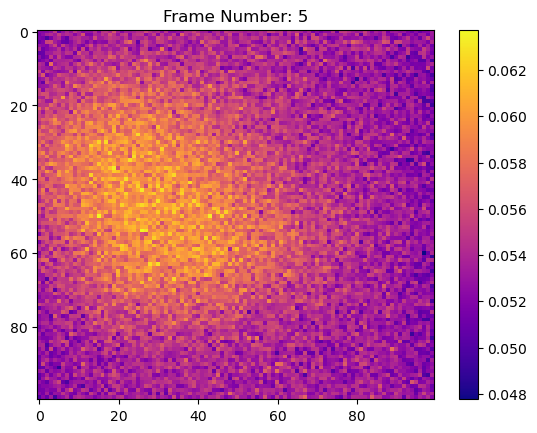

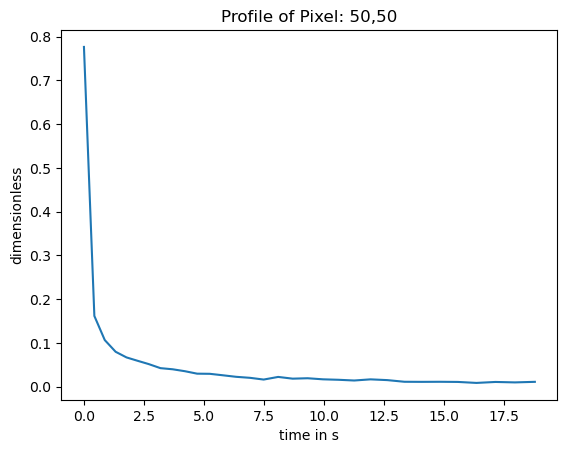

defect


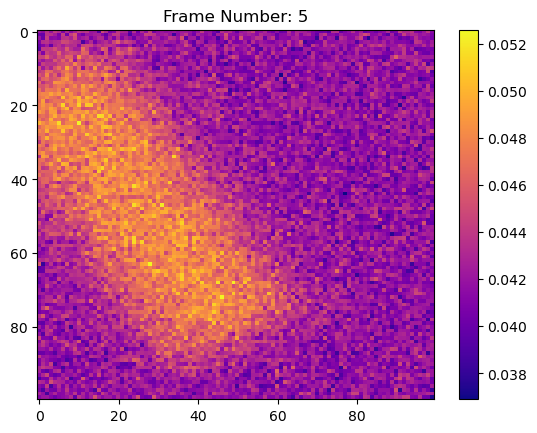

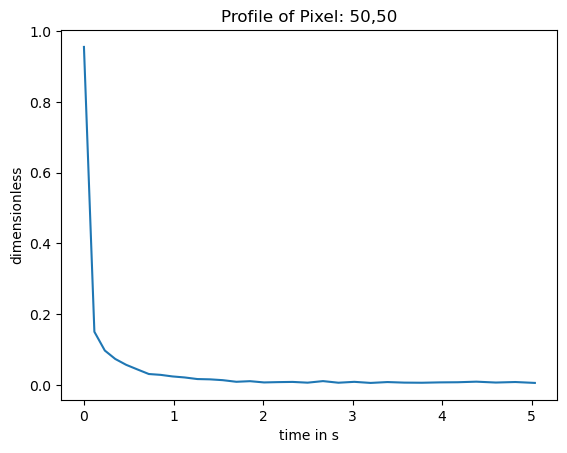

In [10]:
# Visualize the data input
# Visualize a no-defect sample
container = train_set[1]
print("no-defect" if container.get_dataset("/GroundTruth/DefectMask").equal(torch.zeros(100,100)) else "defect")
container.show_frame(5)
container.show_pixel_profile(50, 50)

# Visualize a defect sample
container = train_set[2]
print("no-defect" if container.get_dataset("/GroundTruth/DefectMask").equal(torch.zeros(100,100)) else "defect")
container.show_frame(5)
container.show_pixel_profile(50, 50)

Before we can start the training we also need to define the model, the loss function and the optimizer:

In [28]:
# Define the model and optimizer
model = DefectClassifier3DCNN(time_dim=32).to(device)
# model = Small3DCNN(time_dim=32, n_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.BCEWithLogitsLoss()

Now we can run the training loop with the following code. The training loop is very simple and only consists of a few lines of code. For real world applications you might want to add more features like logging, early stopping, learning rate scheduling, etc.

In [29]:
# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch}")

    # Set the model to training mode
    model.train()
    print("Training:")
    for batch_idx, (data, label) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Compute the loss
        loss = loss_fn(output, label)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Print the loss
        print(f"Batch {batch_idx}, Loss: {loss.item()}")

    # Evaluate the model
    with torch.no_grad():
        model.eval()
        val_loss_summed = 0
        print("Validation:")
        for batch_idx, (data, label) in enumerate(val_loader):
            # Forward pass
            output = model(data)

            # Compute the loss
            loss = loss_fn(output, label)
            val_loss_summed += loss.item()
        
        print(f"Validation Loss: {val_loss_summed / len(val_loader)}")

Epoch 0
Training:
Batch 0, Loss: 0.679155707359314
Batch 1, Loss: 0.7502483129501343
Batch 2, Loss: 0.7005705833435059
Batch 3, Loss: 0.6860224008560181
Batch 4, Loss: 0.6815723180770874
Batch 5, Loss: 0.7552588582038879
Batch 6, Loss: 0.6945769786834717
Batch 7, Loss: 0.6865009069442749
Batch 8, Loss: 0.6845008134841919
Batch 9, Loss: 0.6919457912445068
Batch 10, Loss: 0.6659664511680603
Batch 11, Loss: 0.6535838842391968
Batch 12, Loss: 0.6602352261543274
Batch 13, Loss: 0.7430638074874878
Batch 14, Loss: 0.6975979804992676
Batch 15, Loss: 0.7525660395622253
Batch 16, Loss: 0.6192666888237
Batch 17, Loss: 0.6456747055053711
Batch 18, Loss: 0.7384275794029236
Batch 19, Loss: 0.5890253186225891
Batch 20, Loss: 0.6602317094802856
Batch 21, Loss: 0.7138489484786987
Batch 22, Loss: 0.7752466201782227
Batch 23, Loss: 0.6966480016708374
Batch 24, Loss: 0.7001389265060425
Batch 25, Loss: 0.6570926904678345
Batch 26, Loss: 0.6771937608718872
Batch 27, Loss: 0.7100323438644409
Batch 28, Loss: 

In [34]:
data, label = next(iter(train_loader))
output = model(data)
print("Labels: ", label)
print("Raw Model Outputs (logits):", output)

Labels:  tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.]], device='cuda:0')
Raw Model Outputs (logits): tensor([[-2.3817e-01],
        [-3.0064e-01],
        [ 7.0391e-01],
        [-1.7090e-01],
        [-2.7059e-01],
        [ 5.5320e-01],
        [-2.6254e-01],
        [ 2.9059e-04],
        [-7.2724e-02],
        [-3.0892e-02],
        [-1.6922e-01],
        [-2.4599e-01],
        [-1.4399e-01],
        [-2.4321e-01],
        [-2.8316e-01],
        [-2.7074e-01],
        [ 1.1681e+00],
        [ 3.1411e+00],
        [-9.0148e-02],
        [ 1.6649e+00],
        [ 2.9843e+00],
        [ 1.18

In [16]:
# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch}")

    # Set the model to training mode
    model.train()
    print("Training:")
    for batch_idx, (data, label) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Compute the loss
        loss = loss_fn(output, label)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Print the loss
        print(f"Batch {batch_idx}, Loss: {loss.item()}")

    # Evaluate the model
    with torch.no_grad():
        model.eval()
        val_loss_summed = 0
        print("Validation:")
        for batch_idx, (data, label) in enumerate(val_loader):
            # Forward pass
            output = model(data)

            # Compute the loss
            loss = loss_fn(output, label)
            val_loss_summed += loss.item()
        
        print(f"Validation Loss: {val_loss_summed / len(val_loader)}")

Epoch 0
Training:
Batch 0, Loss: 0.6411629319190979
Batch 1, Loss: 0.4863221049308777
Batch 2, Loss: 0.5400837063789368
Batch 3, Loss: 0.48047277331352234
Batch 4, Loss: 0.6611508727073669
Batch 5, Loss: 0.6082640886306763
Batch 6, Loss: 0.7517476081848145
Batch 7, Loss: 0.3883764445781708
Batch 8, Loss: 0.6048351526260376
Batch 9, Loss: 0.49611902236938477
Batch 10, Loss: 0.595183253288269
Batch 11, Loss: 0.5899491310119629
Batch 12, Loss: 0.6182618141174316
Batch 13, Loss: 0.5822895765304565
Batch 14, Loss: 0.6669865846633911
Batch 15, Loss: 0.5389220714569092
Batch 16, Loss: 0.4975411295890808
Batch 17, Loss: 0.4929007887840271
Batch 18, Loss: 0.5211972594261169
Batch 19, Loss: 0.48627230525016785
Validation:
Validation Loss: 0.6394460439682007
Epoch 1
Training:
Batch 0, Loss: 0.5589407682418823
Batch 1, Loss: 0.5391918420791626
Batch 2, Loss: 0.5276094675064087
Batch 3, Loss: 0.5157665610313416
Batch 4, Loss: 0.49037599563598633
Batch 5, Loss: 0.5229027271270752
Batch 6, Loss: 0.47